<h1>
<hr style=" border:none; height:3px;">
<center>SHIA - Results analysis</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE | Ambroise MARTIN-ROUVILLE | Paul-Alexandre MARENGHI | Paul LE BELLOCH</center></h4>

# 0 - Imports

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_rel
from scipy.stats import f_oneway

# Data analysis

# I.1 - Reading

In [7]:
df_joy = pd.read_excel('./Data/results.xlsx', sheet_name='Joy')
df_joy.head(12)

,Emotion,# questions,N° example,Music pertinence,VAD pertinence
0,Joy,1.0,1.0,2.0,NaN
1,NaN,NaN,2.0,4.0,NaN
2,NaN,NaN,3.0,1.0,NaN
3,NaN,NaN,4.0,3.0,NaN
4,NaN,NaN,5.0,1.0,NaN
5,NaN,NaN,6.0,0.0,NaN
6,NaN,NaN,7.0,3.0,NaN
7,NaN,NaN,8.0,4.0,NaN
8,NaN,NaN,9.0,1.0,NaN
9,NaN,NaN,10.0,1.0,NaN


In [4]:
df_anger = pd.read_excel('./Data/results.xlsx', sheet_name='Anger')
df_anger.head(1)

,Emotion,# questions,N° example,Range
0,Anger,1.0,1.0,NaN


In [5]:
df_sadness = pd.read_excel('./Data/results.xlsx', sheet_name='Sadness')
df_sadness.head(1)

,Emotion,# questions,N° example,Music pertinence,VAD pertinence
0,Sadness,1.0,1.0,4.0,NaN


In [6]:
df_fear = pd.read_excel('./Data/results.xlsx', sheet_name='Fear')
df_fear.head(1)

,Emotion,# questions,N° example,Music pertinence,VAD pertinence
0,Fear,1.0,1.0,5.0,NaN


## I.2 - Pre-processing

In [24]:
def clean_emotion_dataframe(df_raw):
    df_cleaned = df_raw.ffill()
    df_cleaned = df_cleaned.dropna(subset=["N° example"])
    df_cleaned = df_cleaned.rename(columns={
        "Emotion": "Emotion",
        "# questions": "# question",
        "N° example": "# example",
        "Music pertinence": "Music pertinence",
        "VAD pertinence": "AD pertinence"
    })
    df_cleaned = df_cleaned.reset_index(drop=True)
    df_cleaned = df_cleaned[['Emotion', '# question', 'Music pertinence', 'AD pertinence']]
    return df_cleaned

cleaned_fear_df = clean_emotion_dataframe(df_fear)
cleaned_fear_df.head(32)

,Emotion,# question,Music pertinence,AD pertinence
0,Fear,1.0,5.0,NaN
1,Fear,1.0,4.0,NaN
2,Fear,1.0,3.0,NaN
3,Fear,1.0,4.0,NaN
4,Fear,1.0,4.0,NaN
5,Fear,1.0,2.0,NaN
6,Fear,1.0,2.0,NaN
7,Fear,1.0,3.0,NaN
8,Fear,1.0,4.0,NaN
9,Fear,1.0,0.0,NaN


In [17]:
cleaned_joy_df = clean_emotion_dataframe(df_joy)
cleaned_sadness_df = clean_emotion_dataframe(df_sadness)
# cleaned_anger_df = clean_emotion_dataframe(df_anger) # → Need harmonization

## I.3 - Paired T-test

<div class="alert alert-block alert-info">

The <b>t-test</b> approach involves conducting <b>paired t-tests</b> within each emotion category (e.g., joy, sadness, anger) to compare sentiment scores at different stages — specifically testing whether <b>μ(score₁) = μ(score₂)</b> and/or <b>μ(score₁) = μ(score₃)</b>, where score₁ (resp. score₂) is the score of the experiment after one question (resp. 2 questions). 

<br>
This test assesses whether there is a statistically significant increase in sentiment score over time within each emotion group (if p_value < 0.05 we can reject the null hypothesis). We expect that for some emotions, especially those reflecting improvement or engagement (e.g., sadness), the scores might increase, supporting the hypothesis that <b>sentiments evolve positively</b> across the interaction.

</div>


# question  1.0  4.0  7.0
example_id               
0           5.0  4.0  5.0
1           4.0  3.0  4.0
2           3.0  1.0  4.0
3           4.0  3.0  0.0
4           4.0  4.0  5.0
5           2.0  5.0  4.0
6           2.0  2.0  3.0
7           3.0  2.0  4.0
8           4.0  3.0  5.0
9           0.0  5.0  2.0
# question  1.0  4.0  7.0
example_id               
0           2.0  2.0  3.0
1           4.0  3.0  5.0
2           1.0  1.0  4.0
3           3.0  4.0  3.0
4           1.0  1.0  5.0
5           0.0  4.0  3.0
6           3.0  5.0  3.0
7           4.0  3.0  5.0
8           1.0  3.0  5.0
9           1.0  4.0  4.0
# question  1.0  4.0  7.0
example_id               
0           4.0  5.0  5.0
1           4.0  1.0  4.0
2           0.0  2.0  4.0
3           4.0  0.0  4.0
4           4.0  0.0  2.0
5           2.0  5.0  2.0
6           3.0  2.0  5.0
7           2.0  2.0  4.0
8           4.0  1.0  5.0
9           1.0  1.0  4.0


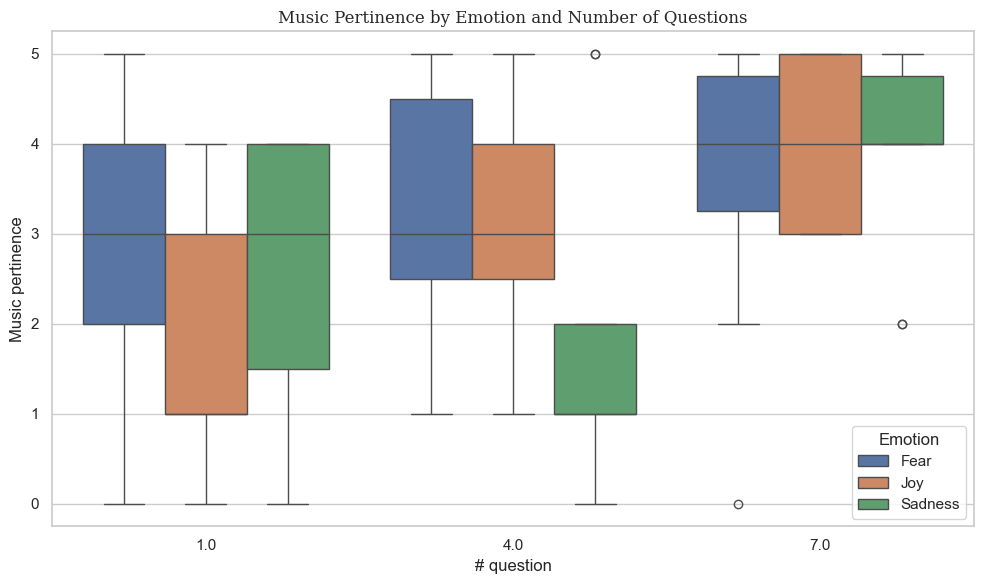

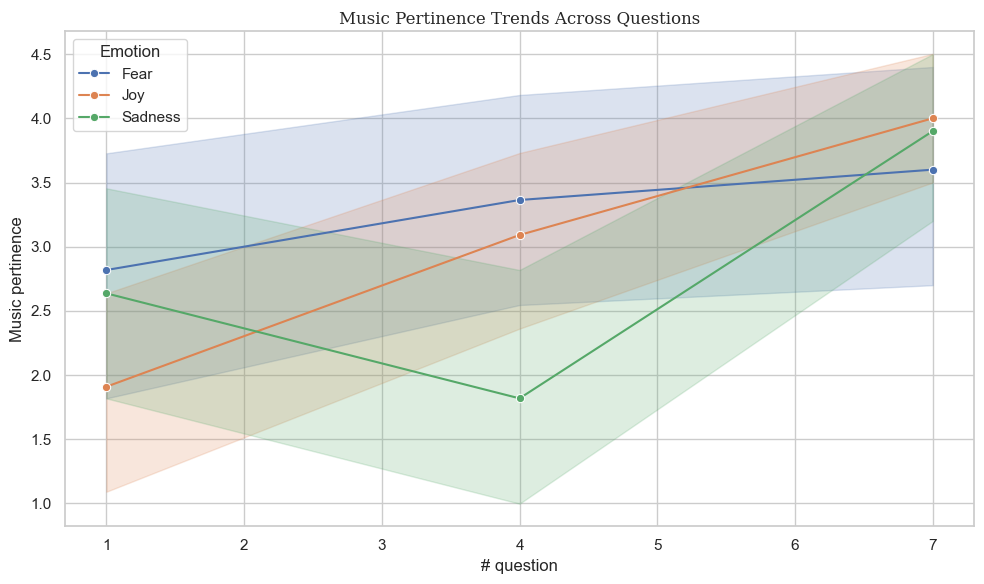

In [27]:
df_all = pd.concat([cleaned_fear_df, cleaned_joy_df, cleaned_sadness_df])

# Pivot for paired t-test: one row per example, columns are score after 1, 4, and 7 questions
def pivot_for_ttest(df, value_col):
    return df.pivot(index=df.groupby('# question').cumcount(), columns="# question", values=value_col)

# Conduct paired t-tests for each emotion
ttest_results = {}
for emotion, group in df_all.groupby("Emotion"):
    group = group.copy()
    group["example_id"] = group.groupby('# question').cumcount()
    pivoted = group.pivot(index="example_id", columns="# question", values="Music pertinence")
    pivoted = pivoted.dropna().iloc[:10]
    print(pivoted)
    if {1, 4, 7}.issubset(pivoted.columns):
        t1_4 = ttest_rel(pivoted[1], pivoted[4])
        t1_7 = ttest_rel(pivoted[1], pivoted[7])
        t4_7 = ttest_rel(pivoted[4], pivoted[7])
        ttest_results[emotion] = {
            "1 vs 4": t1_4,
            "1 vs 7": t1_7,
            "4 vs 7": t4_7
        }

# Visualizations
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x="# question", y="Music pertinence", hue="Emotion")
plt.title("Music Pertinence by Emotion and Number of Questions", fontname='serif')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_all, x="# question", y="Music pertinence", hue="Emotion", marker="o")
plt.title("Music Pertinence Trends Across Questions", fontname='serif')
plt.tight_layout()
plt.show()

In [28]:
print(ttest_results)

{'Fear': {'1 vs 4': TtestResult(statistic=-0.14484136487558028, pvalue=0.8880278648143358, df=9), '1 vs 7': TtestResult(statistic=-0.9214426752509267, pvalue=0.3808561812412816, df=9), '4 vs 7': TtestResult(statistic=-0.6123724356957945, pvalue=0.5554454421055857, df=9)}, 'Joy': {'1 vs 4': TtestResult(statistic=-1.8605210188381265, pvalue=0.09573390947125936, df=9), '1 vs 7': TtestResult(statistic=-4.0451991747794525, pvalue=0.002905806938735551, df=9), '4 vs 7': TtestResult(statistic=-1.6269784336399213, pvalue=0.13818475535118327, df=9)}, 'Sadness': {'1 vs 4': TtestResult(statistic=1.1318988820058602, pvalue=0.2869329189949543, df=9), '1 vs 7': TtestResult(statistic=-2.012045510803985, pvalue=0.07507983017249271, df=9), '4 vs 7': TtestResult(statistic=-2.9999999999999996, pvalue=0.014956363910414203, df=9)}}


<div class='alert alert-bloc alert-info'>
Paired t-tests → Not statiscally relevant as there are too many groups. We should use the ANOVA test.
</div>

## I.4 - Anova Test

<div class="alert alert-block alert-info">

The <b>ANOVA test</b> (Analysis of Variance) is used to compare sentiment scores after 1, 4, and 7 questions within each emotion category. It tests whether there are <b>statistically significant differences between the means</b> of the groups defined by the number of questions asked. Unlike the Friedman test, ANOVA assumes <b>normally distributed data and homogeneity of variances</b>, but it offers a parametric approach to detect overall effects of interaction length on sentiment. We expect the ANOVA test to reveal <b>whether the average sentiment score changes significantly</b> as users are asked more questions, reflecting the emotional trajectory across the interaction.

</div>


In [30]:
anova_results = {}

for emotion, group in df_all.groupby("Emotion"):
    scores_by_question = [group[group["# question"] == q]["Music pertinence"].dropna() for q in sorted(group["# question"].unique())]
    
    if len(scores_by_question) >= 2:
        anova = f_oneway(*scores_by_question)
        anova_results[emotion] = anova

anova_results

{'Fear': F_onewayResult(statistic=0.722693531283139, pvalue=0.49397983761085107),
 'Joy': F_onewayResult(statistic=7.6608207987551875, pvalue=0.002132265721460359),
 'Sadness': F_onewayResult(statistic=5.2679780948263435, pvalue=0.011178496387014599)}

In [31]:
scores_by_question = [
    group["Music pertinence"].dropna()
    for q, group in df_all.groupby("# question")
]

if len(scores_by_question) >= 2:
    general_anova = f_oneway(*scores_by_question)
    print(general_anova)
else:
    print("Not enough groups to perform ANOVA.")

F_onewayResult(statistic=7.713456086554043, pvalue=0.0007953942113964114)


<div class='alert alert-bloc alert-success'>
We can conclude with the <b>ANOVA test that the average sentiment changes as the number of questions increases</b>.
However, we stratify the test per category (emotion), <b>we can only conclude on the emotion 'Joy'</b>, likely due to the low number of samples (around 30).
</div>